# Time Series Project: Amazon Stock Data

Coded by Luna McBride

This is a project meant to mess with time series data. I will be using the opening rate as the key metric, as it is consistent. The below sources are ones I am using to get an idea of the functions and concepts behind the practice. 

Sources: https://www.kaggle.com/gayatry/population-prediction-ar-vs-arima , https://www.youtube.com/watch?v=e8Yw4alG16Q

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Plotting
%matplotlib inline

import warnings #What to do with warnings
warnings.filterwarnings("ignore") #Ignore the warnings

plt.rcParams["figure.figsize"] = (10,10) #Make the plots bigger by default
plt.rcParams["lines.linewidth"] = 2 #Setting the default line width
plt.style.use("ggplot") #Define the style of the plot

from statsmodels.tsa.seasonal import seasonal_decompose #Describes the time data
from statsmodels.tsa.stattools import adfuller #Check if data is stationary
from statsmodels.graphics.tsaplots import plot_acf #Compute lag for ARIMA
from statsmodels.graphics.tsaplots import plot_pacf #Compute partial lag for ARIMA
from statsmodels.tsa.arima_model import ARIMA #Predictions and Forecasting

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-stock-price-1997-to-2020/Amazon.csv


In [2]:
amazon = pd.read_csv("../input/amazon-stock-price-1997-to-2020/Amazon.csv") #Get our stock data from the CSV
amazon.head(10) #Take a peek at the Amazon data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800


---

# Check for Null Values

In [3]:
print(amazon.isnull().any()) #Check for null values

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


There are no null values.

---

# Create Subset for Values I Want

In [4]:
amazonOpen = amazon[["Date", "Open"]].copy() #Get the date and open columns
amazonOpen["Date"] = pd.to_datetime(amazonOpen["Date"]) #Ensure the date data is in datetime format
amazonOpen.set_index("Date", inplace = True) #Set the date to the index
amazonOpen = amazonOpen.asfreq("b") #Set the frequency
amazonOpen = amazonOpen.fillna(method  = "bfill") #Fill null values with future values

#amazonOpen.index #Make sure the frequency remains intact
amazonOpen.head(12) #Take a peek at the open data

,Open
Date,
1997-05-15,2.437500
1997-05-16,1.968750
1997-05-19,1.760417
1997-05-20,1.729167
1997-05-21,1.635417
1997-05-22,1.437500
1997-05-23,1.406250
1997-05-26,1.510417
1997-05-27,1.510417


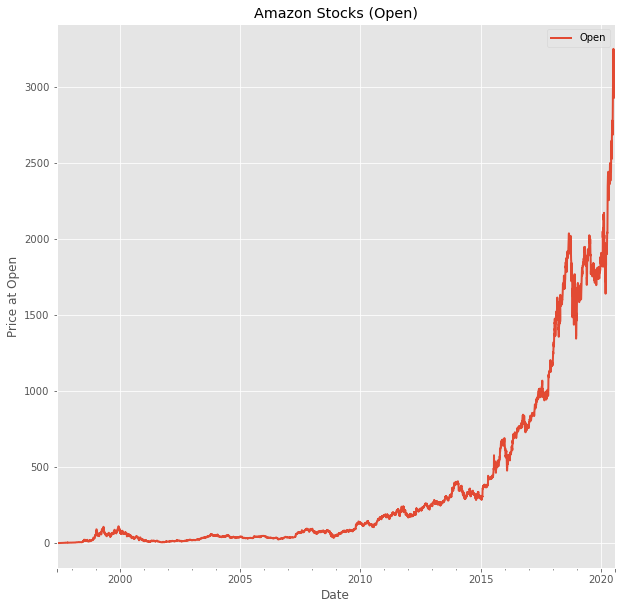

In [5]:
y = amazonOpen.plot(title = "Amazon Stocks (Open)") #Get an idea of the data
y.set(ylabel = "Price at Open") #Set the y label to open
plt.show() #Show the plot

---

# Check Trend/Seasonality

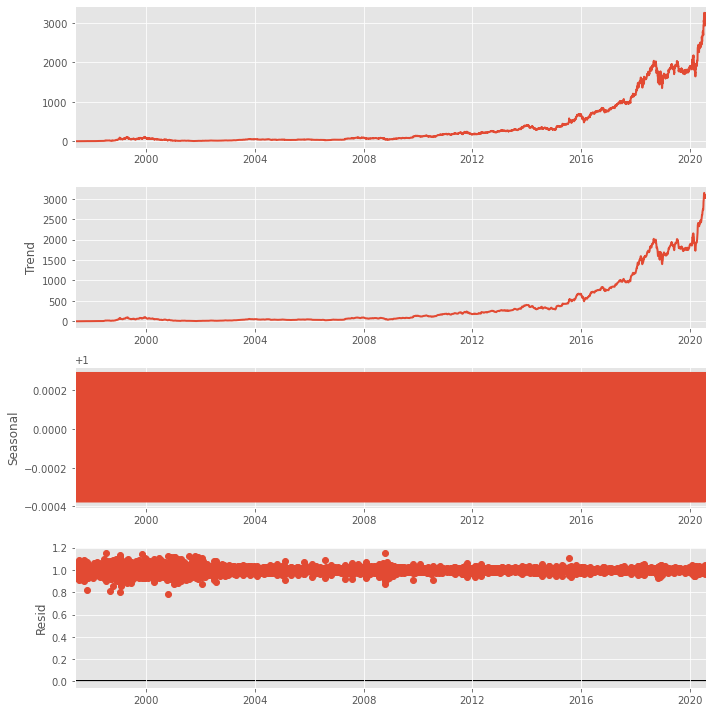

In [6]:
decomp = seasonal_decompose(amazonOpen, model = "multiplicative") #Decompose the data
x = decomp.plot() #Plot the decomposed data

The seasonal looks like a red blob, but the trend is positive.

---

# Check if Data is Stationary

In [7]:
print("ADFuller Test; Significance: 0.05") #Print the significance level
adf = adfuller(amazonOpen["Open"]) #Call adfuller to test
print("ADF test static is {}".format(adf[1])) #Print the adfuller results

ADFuller Test; Significance: 0.05
ADF test static is 1.0


ADFuller gave a clean 1.0. That means this data is not stationary, even for huge significance values.

---

# Make the Data Stationary

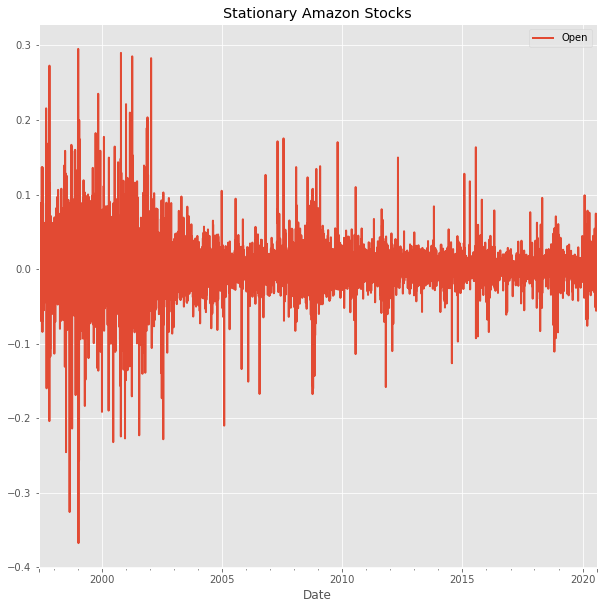

In [8]:
openLog = np.log(amazonOpen) #Take the log of the set for normalization
openStationary = openLog - openLog.shift() #Get a stationary set by subtracting the shifted set
openStationary = openStationary.dropna() #Drop generated null values from the set
openStationary.plot(title = "Stationary Amazon Stocks") #Plot the stationary set

In [9]:
print("ADFuller Test; Significance: 0.05") #Print the significance level
adf = adfuller(openStationary["Open"]) #Call adfuller to test
print("ADF test static is {}".format(adf[1])) #Print the adfuller results

ADFuller Test; Significance: 0.05
ADF test static is 0.0


ADFuller is now below significance. The data is now stationary.

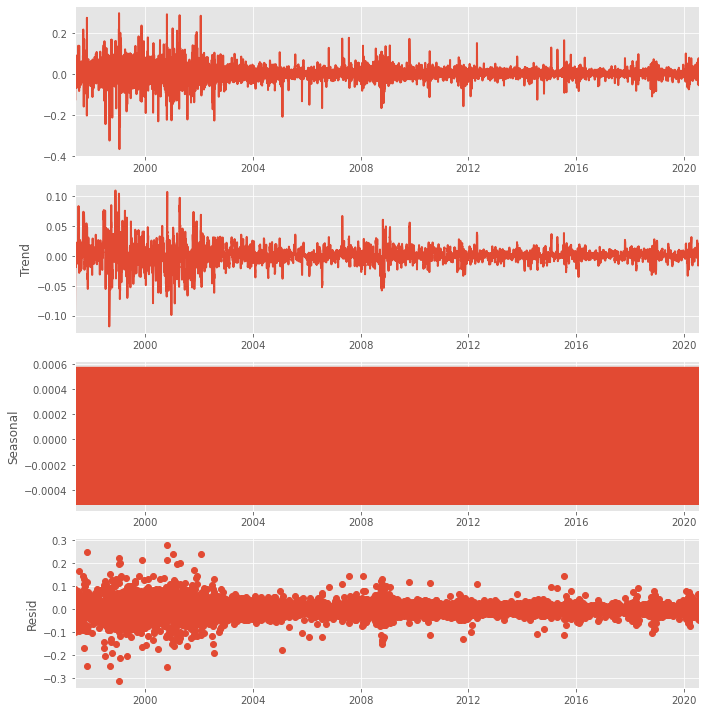

In [10]:
decomp = seasonal_decompose(openStationary) #Decompose the stationary data
x = decomp.plot() #Plot the decomposition

---

# Preparation for ARIMA

## Differencing Term D

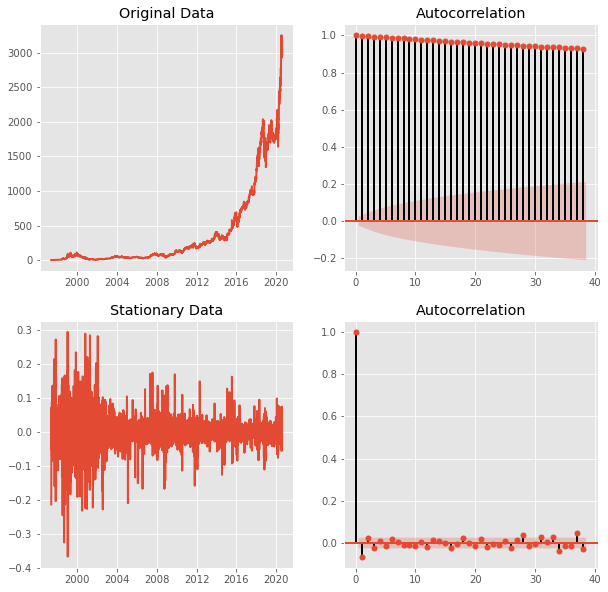

In [11]:
fig,axes = plt.subplots(2,2) #Set a subset for the data visualizations

a = axes[0,0].plot(amazonOpen["Open"]) #Plot the original data
a = axes[0,0].set_title("Original Data") #Give the original data a name
b = plot_acf(amazonOpen["Open"],ax=axes[0,1]) #Plot the ACF of the original data

x = axes[1,0].plot(openStationary["Open"]) #Plot the stationary data
x = axes[1,0].set_title("Stationary Data") #Give the stationary data a name
y = plot_acf(openStationary["Open"],ax=axes[1,1]) #Plot the ACF of the stationary data

The Stationary data appears to be mostly in the fair range, with some variance due to the large jump in the data. 1 appears to be a good number for D.

## AR Lag (P)

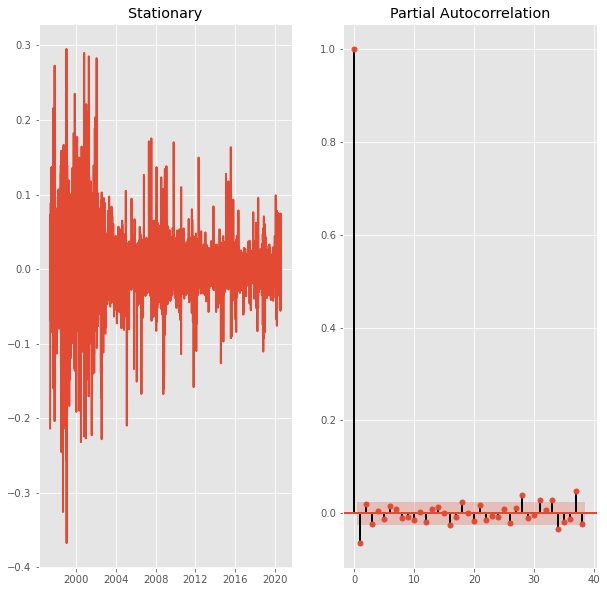

In [12]:
fig,axes = plt.subplots(1,2) #Create a subplot for the Partial ACF

a = axes[0].plot(openStationary["Open"]) #Plot the stationary data
a = axes[0].set_title("Stationary") #Ensure the stationary data is named
b = plot_pacf(openStationary["Open"], ax = axes[1], method = "ols") #Plot the partial ACF

5 appears to be a good number for P.

## MA Lag (Q)

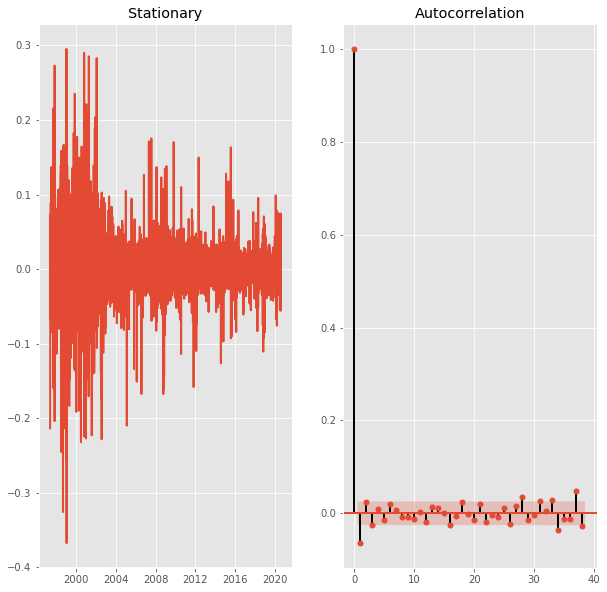

In [13]:
fig,axes = plt.subplots(1,2) #Create a subplot for the ACF

a = axes[0].plot(openStationary["Open"])#Plot the stationary data
a = axes[0].set_title("Stationary") #Ensure the stationary data is named
b = plot_acf(openStationary["Open"], ax = axes[1]) #Plot the ACF

5 appears to be a good number for the Q metric as well.

---

# Train the ARIMA

In [14]:
model = ARIMA(openStationary, order = (5, 1, 5)) #Build the ARIMA model
fitModel = model.fit(disp = 1) #Fit the ARIMA model

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


---

# Predict with ARIMA

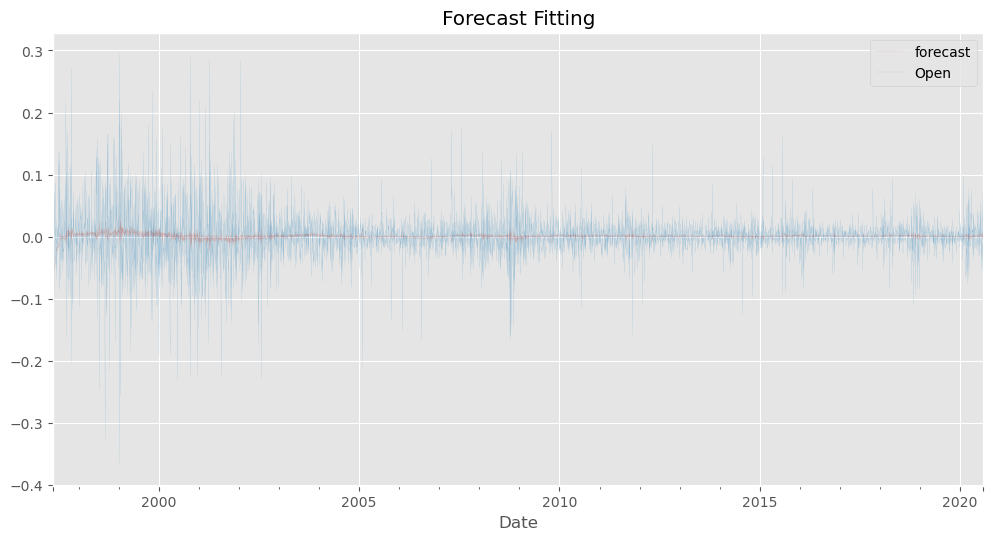

In [15]:
plt.rcParams.update({"figure.figsize" : (12,6), "lines.linewidth" : 0.05, "figure.dpi" : 100}) #Fix the look of the graph, dimming it to show the red

x = fitModel.plot_predict(dynamic = False) #Fit the ARIMA model
x = plt.title("Forecast Fitting") #Add a stock title
plt.show() #Show the ARIMA plot

---

# Validation

In [16]:
plt.rcParams.update({"figure.figsize" : (12,5), "lines.linewidth": 2}) #Fix the line width
length = int((len(amazonOpen)*9)/10) #Get 9/10 of the length of the data
print(length) #Print the length to make sure it actually is an int

5451


In [17]:
train = amazonOpen[:length] #Use 9/10 of the data for the train set
test = amazonOpen[length:] #Use the rest for testing
modelValid = ARIMA(train,order=(5,1,5)) #Create a model for the train set
fitModelValid = modelValid.fit(disp= -1) #Fit the model

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [18]:
fc,se,conf = fitModelValid.forecast(len(amazonOpen) - length) #Forcast over the test area
forecast = pd.Series(fc, index = test.index) #Get the forecast for the area

Text(0, 0.5, 'Open Price')

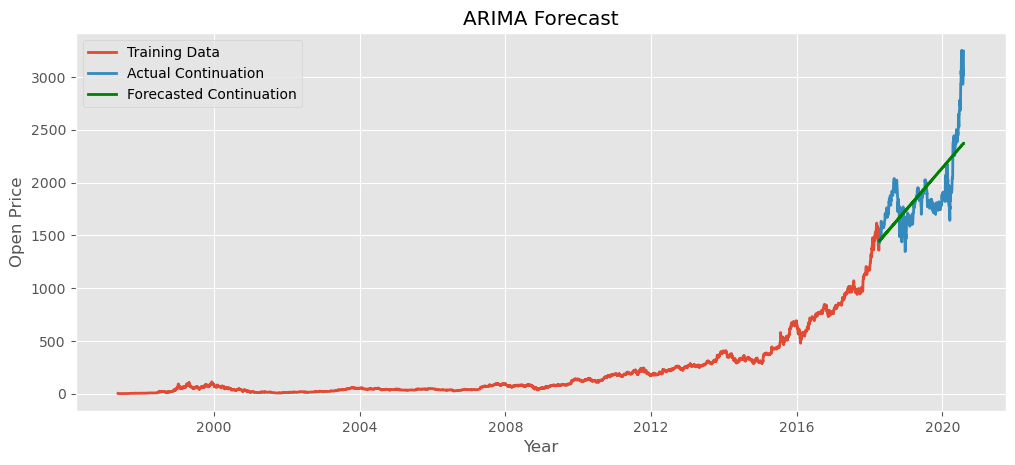

In [19]:
#Add labels for the train, test, and forecast
plt.plot(train,label = "Training Data") 
plt.plot(test,label = "Actual Continuation")
plt.plot(forecast,label = "Forecasted Continuation", color = "g")

plt.title("ARIMA Forecast") #Add the Forecast title
plt.legend(loc = "upper left") #Put the legend in the top left
plt.xlabel("Year") #Add the year label to the bottom
plt.ylabel("Open Price") #Add the open price to the y axis

Putting 1/10 of the test data for the stocks appears to show a fair prediction for the open price. It had to go far enough to account for the massive growth in the late 2010's. It does not account for the massive jump in 2020, but 2020 is an anomoly for Amazon stocks, given Covid.

---

# Predicting

In [20]:
modelPred = ARIMA(amazonOpen,order=(5,1,5)) #Create a model for the whole data
fitModelPred = modelPred.fit(disp= -1) #Fit the model

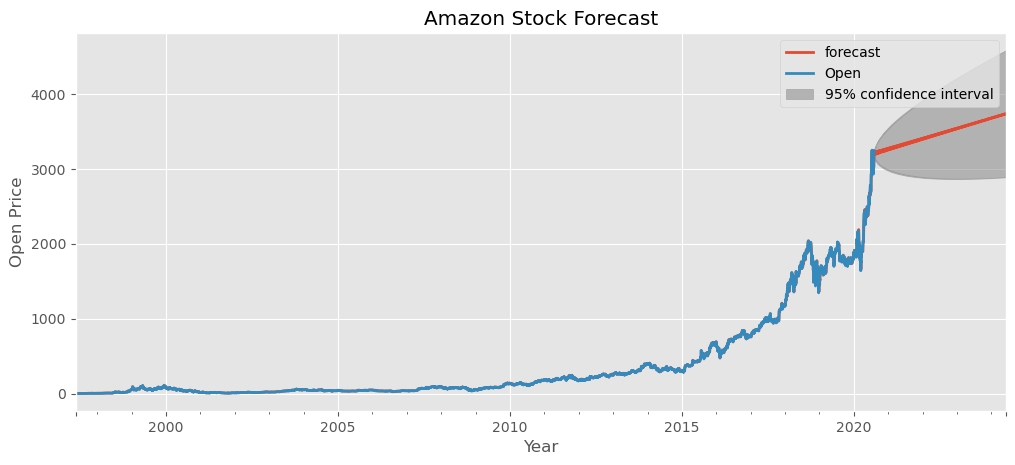

In [21]:
fitModelPred.plot_predict(1,len(amazonOpen) + 1000) #Plot predictions for the next thousand days
x = fitModelPred.forecast(1000) #Forecast the prediction for the next thousand days.
x = plt.title("Amazon Stock Forecast") #Add a stock title
x = plt.xlabel("Year") #Add the year label to the bottom
x = plt.ylabel("Open Price") #Add the open price to the y axis

The model predicts an overall increase in stock price. The slope of the prediction is more akin to how level the majority of the graph is, but the confidence interval is wide to account for variance. In this case, the spike caused by Covid is likely the big indicator for why in the interval is so large. In general, it is fair to assume Amazon stocks will continue to rise given previous trends, but we need to keep in mind we are coming out of a pandemic. We will likely continue to feel its wrath linger long after it is handled, which could cause unexpected spikes or dips from people getting back to life and deciding whether or not to continue using Amazon services as much as they have. At the current moment, however, this feels like a fair prediction.